# Comparing fiberassign to platemaker

Compare fiberassign x,y to platemaker x,y using tile 63017 observed on
night 20191113 expid 27552

In [1]:
night = 20191113
expid = 27552
tileid = 63017

In [2]:
%pylab inline
import os, sys, tarfile
import numpy as np
from astropy.table import Table

Populating the interactive namespace from numpy and matplotlib


In [3]:
#- Create output directory
workdir = os.path.expandvars('/global/project/projectdirs/desi/users/$USER/platemaker')
os.makedirs(workdir, exist_ok=True)
os.chdir(workdir)

In [4]:
#- Extract platemaker positioner info from pm tarball
datadir = '/project/projectdirs/desi/spectro/data/{}/{:08d}'.format(night, expid)
t = tarfile.open(datadir+'/pm-{:08d}-logs.tar'.format(expid))
pmposfile = 'data/platemaker/test/{expid}/positioner-pos-{expid}.2.dat'.format(expid=expid)
t.extract(pmposfile)

In [5]:
tile

<function numpy.tile(A, reps)>

In [6]:
#- read platemaker (pm) and fiberassign (fa) files
pm = Table.read(pmposfile, format='ascii.commented_header')
fa = Table.read(datadir+'/fiberassign-{:06d}.fits'.format(tileid), 'FIBERASSIGN')

In [7]:
pm.colnames

['PETAL_LOC',
 'DEVICE_LOC',
 'DEVICE_TYPE',
 'XFPA',
 'YFPA',
 'Q',
 'S',
 'XPIX',
 'YPIX',
 'FLAGS']

In [8]:
#- Trim to just POS (not ETC) and sort by LOCATION = 1000*PETAL_LOC + DEVICE_LOC
pm = pm[pm['DEVICE_TYPE'] == 'POS']
pm['LOCATION'] = 1000*pm['PETAL_LOC'] + pm['DEVICE_LOC']
pm.sort('LOCATION')

#- Also sort fa by location so the two should match
fa.sort('LOCATION')

# Raw differences

In [9]:
fa_x = np.asarray(fa['FIBERASSIGN_X'])
fa_y = np.asarray(fa['FIBERASSIGN_Y'])
pm_x = np.asarray(pm['XFPA'])
pm_y = np.asarray(pm['YFPA'])

Text(0.5,1,'Platemaker - FiberAssign positioner x,y differences [um]')

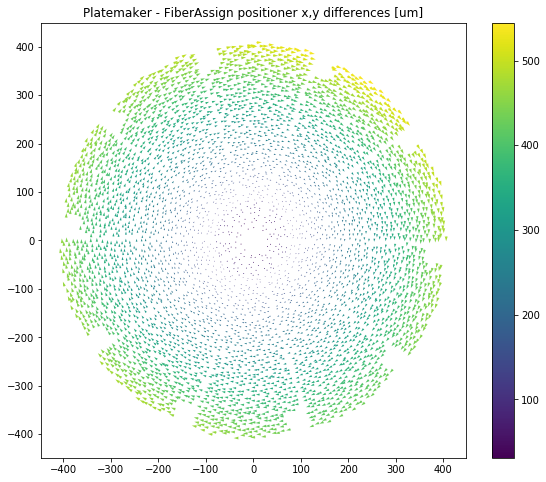

In [10]:
figure(figsize=(9.5,8))
dxy = np.sqrt((pm_x-fa_x)**2 + (pm_y-fa_y)**2)
quiver(fa_x, fa_y, pm_x-fa_x, pm_y-fa_y, dxy*1000)
colorbar()
title('Platemaker - FiberAssign positioner x,y differences [um]')

# Solve for scale, rotation, offset

```
pm_x = (fa_x*cos(rotation) - fa_y*sin(rotation)) * scale + offset_x
pm_y = (fa_x*sin(rotation) + fa_y*cos(rotation)) * scale + offset_y
```

In [11]:
from scipy.optimize import minimize

def transform(x, y, scale, rotation, offset_x, offset_y):
    xx = (x*np.cos(rotation) - y*np.sin(rotation))*scale + offset_x
    yy = (x*np.sin(rotation) + y*np.cos(rotation))*scale + offset_y
    return xx, yy

def func(params, fa_x, fa_y, pm_x, pm_y):
    scale, rotation, offset_x, offset_y = params
    x, y = transform(fa_x, fa_y, scale, rotation, offset_x, offset_y)    
    dr2 = np.sum((pm_x-x)**2 + (pm_y-y)**2)
    return dr2

p0 = np.array([1.0, 0.0, 0.0, 0.0])
p = minimize(func, p0, args=(fa_x, fa_y, pm_x, pm_y), method='Nelder-Mead')
p.success

True

In [12]:
scale, rotation, offset_x, offset_y = p.x
print('Scale      = {:.4f}'.format(scale))
print('Rotation   = {:.4f} deg'.format(np.degrees(rotation)))
print('offset_x/y = {:.2f},{:.2f} um'.format(1000*offset_x, 1000*offset_y))

Scale      = 1.0000
Rotation   = -0.0674 deg
offset_x/y = 0.40,0.30 um


In [13]:
xx, yy = transform(fa_x, fa_y, *p.x)

Text(0.5,1,'Residual PM-FA offsets [um] after -0.0674 deg rotation')

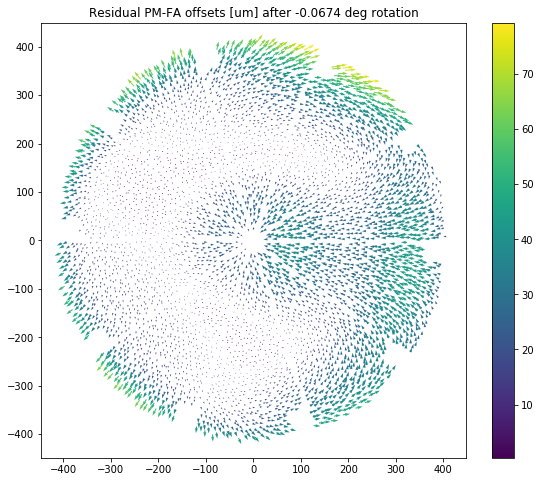

In [14]:
figure(figsize=(9.5,8))
dxy = np.sqrt((pm_x-xx)**2 + (pm_y-yy)**2)
quiver(fa_x, fa_y, pm_x-xx, pm_y-yy, dxy*1000)
colorbar()
title('Residual PM-FA offsets [um] after {:.4f} deg rotation'.format(np.degrees(p.x[1])))

In [15]:
print(np.sqrt(np.mean(dxy**2))*1000)

26.44215804980815


# How does that rotation compare to the FIELDROT?

In [16]:
print('Rotation = {:8.4f} deg'.format(np.degrees(rotation)))
print('FIELDROT = {:8.4f} deg'.format(fa.meta['FIELDROT']))

Rotation =  -0.0674 deg
FIELDROT =   0.0456 deg
